In [53]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import os 
from scipy.ndimage import rotate
from numpy.fft import fftshift
# local files

#import CTfilter as CTfilter

1) Sur le site de XCOM, nous pouvons visualiser l'atténuation dans l'eau d'un rayon de 60 keV. En considérant un faisceau cohérent, l'atténuation pour un rayon de 60 kev est de 0,404 cm$^2$/g. En multipliant par la masse volumique de l'eau de 1 g/cm $^3$ , nous obtenons une valeur de 0,404 cm $^{-1}$. À 5 cm d'eau, il subsiste $0,404 \; \rm{cm^{-1}} \cdot 5 \; \rm{cm} =$. Similairement, à 20 cm, il subsiste $0,404 \; \rm{cm^{-1}} \cdot 20 \; \rm{cm} =$


2) 

In [3]:
## VARIABLES ###

### paramètres d'acquisition ###

## largeur d'un élément de détecteur (cm)
pixsize = 0.165

## taille du détecteur (nombre d'échantillons)
nbpixg = 336

### paramètres de reconstruction ###

## taille de la grille d'image (carrée)
nbvox = 192 # options: 96, 192

## taille du voxel (carré) (cm)
voxsize = 0.2 # option: 0.4, 0.2

## fichiers d'entrée
dataDir = "./TP4/"
anglesFile = "angles.txt"
sinogramFile = "sinogram-password.txt"
#sinogramFile = "sinogram-patient.txt"


In [4]:
def readAngles(filename):

    angles = np.loadtxt(filename)
    nbprj = angles.shape[0]

    # convertir en radians element par element
    angles = (np.pi/180.0)*angles

    return [nbprj, angles]


## lire un sinogramme
def readSinogram(filename):
    
    sinogram = np.loadtxt(filename)
    nbprj = sinogram.shape[0]
    nbpix = sinogram.shape[1]

    return [nbprj, nbpix, sinogram]


#enregistrer l'image
def saveImage(image, prefix):
    im = plt.imshow(image, cmap = cm.Greys_r)
    plt.colorbar()
    plt.title("method: "+prefix)
    plt.savefig(prefix+"-"+time.strftime("%Y%m%d-%H%M%S")+".png")


nbprj: 720
working on image column: 1/192


C:\Users\gaelm\AppData\Local\Temp\ipykernel_14648\675787132.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_xsino = round(float(posi_prime[0]/pixsize))


working on image column: 2/192
working on image column: 3/192
working on image column: 4/192
working on image column: 5/192
working on image column: 6/192
working on image column: 7/192
working on image column: 8/192
working on image column: 9/192
working on image column: 10/192
working on image column: 11/192
working on image column: 12/192
working on image column: 13/192
working on image column: 14/192
working on image column: 15/192
working on image column: 16/192
working on image column: 17/192
working on image column: 18/192
working on image column: 19/192
working on image column: 20/192
working on image column: 21/192
working on image column: 22/192
working on image column: 23/192
working on image column: 24/192
working on image column: 25/192
working on image column: 26/192
working on image column: 27/192
working on image column: 28/192
working on image column: 29/192
working on image column: 30/192
working on image column: 31/192
working on image column: 32/192
working on image

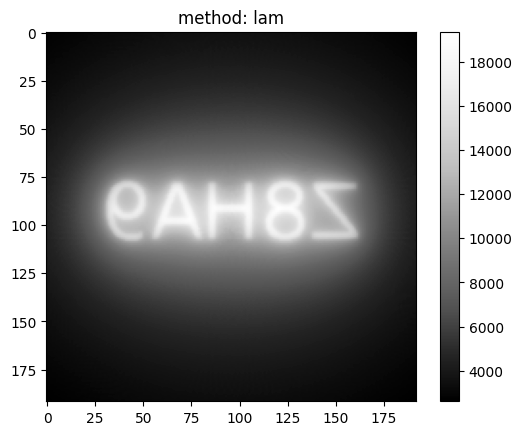

In [52]:
def readInput():
    # lire les angles
    angle_path= os.path.abspath("angles.txt")
    sino_path= os.path.abspath("sinogram-password.txt")
    [nbprj, angles] = readAngles(angle_path)

    print("nbprj:",nbprj)


    # lire le sinogramme
    [nbprj2, nbpix2, sinogram] = readSinogram(sino_path)
    return [nbprj, angles, sinogram]


## reconstruire une image TDM en mode rétroprojection
def laminogram():
    
    [nbprj, angles, sinogram] = readInput()


    # initialiser une image reconstruite
    image = np.zeros((nbvox, nbvox))

    # "etaler" les projections sur l'image
    # ceci sera fait de façon "voxel-driven"
    # pour chaque voxel, trouver la contribution du signal reçu
    center_x = nbvox / 2
    center_y = nbvox / 2
    for j in range(nbvox): # colonnes de l'image
        print("working on image column: "+str(j+1)+"/"+str(nbvox))
        for i in range(nbvox): # lignes de l'image

            x = (j - center_x) * voxsize
            y = (center_y - i) * voxsize
            posi = np.array([[x],
                            [y]])

            for a in range(len(angles)):
                theta = angles[a]

                R = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
                posi_prime = np.matmul(R, posi)



                val_xsino = round(float(posi_prime[0]/pixsize))
   
                image [i, j] += sinogram[a, round(nbpixg/2 + val_xsino)]
             
    saveImage(image, "lam")

laminogram()

nbprj: 720


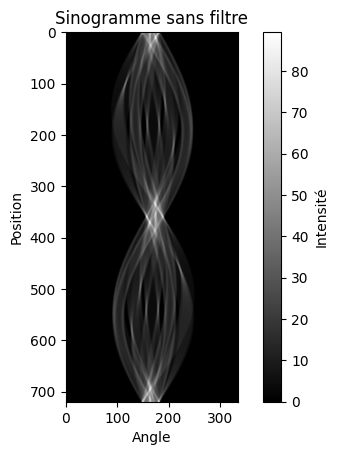

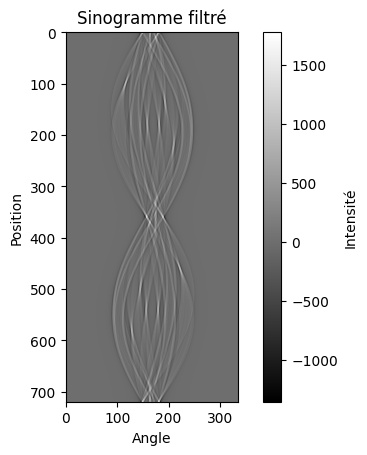

In [100]:
#3 
## filtrer le sinogramme
## ligne par ligne
import numpy as np

def filterSinogram(sinogram):
    filtered_sinogram = np.zeros_like(sinogram)  # Create an array to store filtered sinogram
    for i in range(sinogram.shape[0]):
        filtered_sinogram[i] = filterLine(sinogram[i])
    return filtered_sinogram

def filterLine(projection):
    dft = np.fft.fft(projection)
    frequence_shift = np.fft.fftshift(dft)

    filter_len = len(projection)

    filtre_rampe = np.abs(np.arange(-frequence_shift.shape[0]/2,frequence_shift.shape[0]/2, 1))

    filtre_freq = frequence_shift * filtre_rampe


    filtre_freq = np.fft.ifftshift(filtre_freq)
    filtered_projection = np.fft.ifft(filtre_freq)

    filtered_projection = np.real(filtered_projection)

    return filtered_projection


[nbprj, angles, sinogram] = readInput()
plt.imshow(sinogram, cmap='gray')
plt.title('Sinogramme sans filtre')
plt.xlabel('Angle')
plt.ylabel('Position')
plt.colorbar(label='Intensité')
plt.show()


sinogram = filterSinogram(sinogram)
plt.imshow(sinogram, cmap='gray')
plt.title('Sinogramme filtré')
plt.xlabel('Angle')
plt.ylabel('Position')
plt.colorbar(label='Intensité')
plt.show()


nbprj: 720
working on image column: 1/192


C:\Users\gaelm\AppData\Local\Temp\ipykernel_14648\3761022914.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_xsino = round(float(posi_prime[0]/pixsize))


working on image column: 2/192
working on image column: 3/192
working on image column: 4/192
working on image column: 5/192
working on image column: 6/192
working on image column: 7/192
working on image column: 8/192
working on image column: 9/192
working on image column: 10/192
working on image column: 11/192
working on image column: 12/192
working on image column: 13/192
working on image column: 14/192
working on image column: 15/192
working on image column: 16/192
working on image column: 17/192
working on image column: 18/192
working on image column: 19/192
working on image column: 20/192
working on image column: 21/192
working on image column: 22/192
working on image column: 23/192
working on image column: 24/192
working on image column: 25/192
working on image column: 26/192
working on image column: 27/192
working on image column: 28/192
working on image column: 29/192
working on image column: 30/192
working on image column: 31/192
working on image column: 32/192
working on image

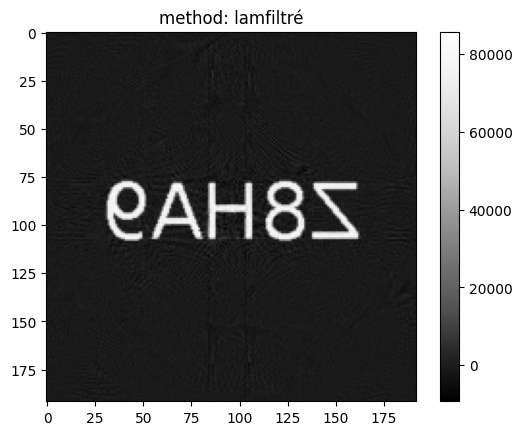

In [102]:
#Q4
def laminogram():
    
    [nbprj, angles, sinogram] = readInput()
    sinogram = filterSinogram(sinogram)

    # initialiser une image reconstruite
    image = np.zeros((nbvox, nbvox))

    # "etaler" les projections sur l'image
    # ceci sera fait de façon "voxel-driven"
    # pour chaque voxel, trouver la contribution du signal reçu
    center_x = nbvox / 2
    center_y = nbvox / 2
    for j in range(nbvox): # colonnes de l'image
        print("working on image column: "+str(j+1)+"/"+str(nbvox))
        for i in range(nbvox): # lignes de l'image

            x = (j - center_x) * voxsize
            y = (center_y - i) * voxsize
            posi = np.array([[x],
                            [y]])

            for a in range(len(angles)):
                theta = angles[a]

                R = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
                posi_prime = np.matmul(R, posi)



                val_xsino = round(float(posi_prime[0]/pixsize))
   
                image [i, j] += sinogram[a, round(nbpixg/2 + val_xsino)]
                  
    saveImage(image, "lamfiltré")

laminogram()

In [ ]:
#Q5